In [1]:
import os
import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from pedalboard import Pedalboard
from pedalboard.io import AudioFile
from IPython.display import Audio
from collections import defaultdict
import time
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import StringLookup
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
labels=os.listdir("data/")

In [74]:
labels

['increase_volume1.mp3',
 'increase_volume2.mp3',
 'next_song1.mp3',
 'next_song2.mp3',
 'pause_music1.mp3',
 'pause_music2.mp3',
 'play_spotify1.mp3',
 'play_spotify2.mp3',
 'processed_1000_increase_volume1.wav',
 'processed_1000_increase_volume2.wav',
 'processed_1000_next_song1.wav',
 'processed_1000_next_song2.wav',
 'processed_1000_pause_music1.wav',
 'processed_1000_pause_music2.wav',
 'processed_1000_play_spotify1.wav',
 'processed_1000_play_spotify2.wav',
 'processed_1000_reduce_volume1.wav',
 'processed_1000_reduce_volume2.wav',
 'processed_1000_skip_song1.wav',
 'processed_1000_skip_song2.wav',
 'processed_1000_stop_music1.wav',
 'processed_1000_stop_music2.wav',
 'processed_1001_increase_volume1.wav',
 'processed_1001_increase_volume2.wav',
 'processed_1001_next_song1.wav',
 'processed_1001_next_song2.wav',
 'processed_1001_pause_music1.wav',
 'processed_1001_pause_music2.wav',
 'processed_1001_play_spotify1.wav',
 'processed_1001_play_spotify2.wav',
 'processed_1001_reduce_

In [3]:
audio_types = {
    "increase_volume1.wav": "increase volume",
    "increase_volume2.wav": "increase volume",
    "next_song1.wav": "next song",
    "next_song2.wav": "next song",
    "pause_music1.wav": "pause music",
    "pause_music2.wav": "pause music",
    "play_spotify1.wav": "play spotify",
    "play_spotify2.wav": "play spotify",
    "reduce_volume1.wav": "reduce volume",
    "reduce_volume2.wav": "reduce volume",
    "skip_song1.wav": "skip song",
    "skip_song2.wav": "skip song",
    "stop_music1.wav": "stop music",
    "stop_music2.wav": "stop music",
}

In [4]:
all_file = []
all_label = []
counter = 0
for label in labels:
    if label[-4:] == ".wav":
        all_file.append(label[:-4])
        if counter % 1000 == 0:
            print(counter)
        for t in audio_types.keys():
            if (t in label):
                all_label.append(audio_types[t]) 
    counter += 1

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000


In [5]:
metadata_df = pd.DataFrame({"file_name": all_file, "transcription": all_label})

In [3]:
metadata_df = pd.read_csv("metadata.csv")

In [4]:
df_train = metadata_df.sample(frac = 0.7)
rest_part_30 = metadata_df.drop(df_train.index)
df_dev = rest_part_30.sample(frac = 0.66)
df_test = rest_part_30.drop(df_dev.index)

In [5]:
# The set of characters accepted in the transcription.
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
# Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

In [6]:
# An integer scalar Tensor. The window length in samples.
frame_length = 256
# An integer scalar Tensor. The number of samples to step.
frame_step = 160
# An integer scalar Tensor. The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384


def encode_single_sample(wav_file, label):
    ###########################################
    ##  Process the Audio
    ##########################################
    # 1. Read wav file
    file = tf.io.read_file('data/' + wav_file + ".wav")
    # 2. Decode the wav file
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    # 3. Change type to float
    audio = tf.cast(audio, tf.float32)
    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    # 6. normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    ###########################################
    ##  Process the label
    ##########################################
    # 7. Convert label to Lower case
    label = tf.strings.lower(label)
    # 8. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # 9. Map the characters in label to numbers
    label = char_to_num(label)
    # 10. Return a dict as our model is expecting two inputs
    return spectrogram, label

In [7]:
batch_size = 32
# Define the trainig dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["transcription"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=AUTOTUNE)
)

# Define the develop dataset
develop_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_dev["file_name"]), list(df_dev["transcription"]))
)
develop_dataset = (
    develop_dataset.map(encode_single_sample, num_parallel_calls=AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=AUTOTUNE)
)

# Define the test dataset
test_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_test["file_name"]), list(df_test["transcription"]))
)
test_dataset = (
    test_dataset.map(encode_single_sample, num_parallel_calls=AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=AUTOTUNE)
)

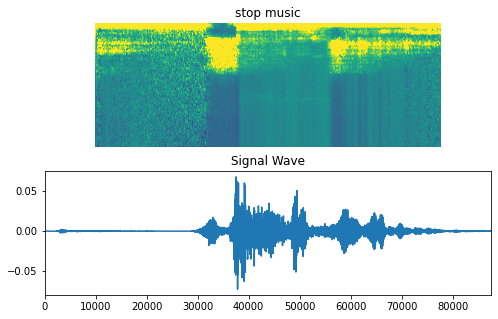

In [8]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # Wav
    file = tf.io.read_file("data/" + list(df_train["file_name"])[0] + ".wav")
    audio, s = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=44100))
plt.show()

In [9]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [10]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
#     x = layers.BatchNormalization(name="conv_1_bn")(x)
#     x = layers.ReLU(name="conv_1_relu")(x)
    # Convolution layer 2
#     x = layers.Conv2D(
#         filters=32,
#         kernel_size=[11, 21],
#         strides=[1, 2],
#         padding="same",
#         use_bias=False,
#         name="conv_2",
#     )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
#     # RNN layers
#     for i in range(1, rnn_layers + 1):
#         recurrent = layers.GRU(
#             units=rnn_units,
#             activation="tanh",
#             recurrent_activation="sigmoid",
#             use_bias=True,
#             return_sequences=True,
#             reset_after=True,
#             name=f"gru_{i}",
#         )
#         x = layers.Bidirectional(
#             recurrent, name=f"bidirectional_{i}", merge_mode="concat"
#         )(x)
#         if i < rnn_layers:
#             x = layers.Dropout(rate=0.5)(x)
#     # Dense layer
#     x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
#     x = layers.ReLU(name="dense_1_relu")(x)
#     x = layers.Dropout(rate=0.5)(x)
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)
    return model


# Get the model
model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)

Model: "DeepSpeech_2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_2_bn (BatchNormalization)                  (None, None, 97, 32)                     

In [14]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)

In [15]:
# Define the number of epochs.
epochs = 5
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(develop_dataset)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=develop_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

Epoch 1/5
613/613 [==============================] - ETA: 0s - loss: 177.0664----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0065
----------------------------------------------------------------------------------------------------
Target    : stop music
Prediction: pt gugugugugugugugugugugugugugugugugugugugic
----------------------------------------------------------------------------------------------------
Target    : stop music
Prediction: sep uguguguguguguguguguguguguguguguguguguguguguguguguguguguguguic
----------------------------------------------------------------------------------------------------
613/613 [==============================] - 3397s 6s/step - loss: 177.0664 - val_loss: 170.7995
Epoch 2/5
613/613 [==============================] - ETA: 0s - loss: 163.1903----------------------------------------------------------------------------------------------------
Word Error Rate: 0.9816
-----------------

In [16]:
model.save('models/epoch_5')

INFO:tensorflow:Assets written to: models/epoch_5\assets


In [18]:
# Let's check results on more validation samples
predictions = []
targets = []
counter = 0
for batch in test_dataset:
    counter += 1
    print(counter, '/', len(test_dataset))
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 10):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)

1 / 90
2 / 90
3 / 90
4 / 90
5 / 90
6 / 90
7 / 90
8 / 90
9 / 90
10 / 90
11 / 90
12 / 90
13 / 90
14 / 90
15 / 90
16 / 90
17 / 90
18 / 90
19 / 90
20 / 90
21 / 90
22 / 90
23 / 90
24 / 90
25 / 90
26 / 90
27 / 90
28 / 90
29 / 90
30 / 90
31 / 90
32 / 90
33 / 90
34 / 90
35 / 90
36 / 90
37 / 90
38 / 90
39 / 90
40 / 90
41 / 90
42 / 90
43 / 90
44 / 90
45 / 90
46 / 90
47 / 90
48 / 90
49 / 90
50 / 90
51 / 90
52 / 90
53 / 90
54 / 90
55 / 90
56 / 90
57 / 90
58 / 90
59 / 90
60 / 90
61 / 90
62 / 90
63 / 90
64 / 90
65 / 90
66 / 90
67 / 90
68 / 90
69 / 90
70 / 90
71 / 90
72 / 90
73 / 90
74 / 90
75 / 90
76 / 90
77 / 90
78 / 90
79 / 90
80 / 90
81 / 90
82 / 90
83 / 90
84 / 90
85 / 90
86 / 90
87 / 90
88 / 90
89 / 90
90 / 90
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.8493
----------------------------------------------------------------------------------------------------
Target    : play spotify
Prediction: plauspouououogouotify
----